<center><img src="pr.png" style="width: 250px;"/></center>

# <center>Solving PageRank in three ways</center>

## 1. BackGround

Consider this situation: you are an investor, you want to choose from four companies A, B, C, and D. The only thing you know is there mutual investment relationship. The relationship is shown in the investment graph below, where an edge from company X to company Y means company X invested some money in company Y. Now you need to decide: which one is the best one to invest? 
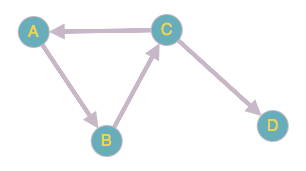

A natural intuition is that if a company X invest in company Y, it means that company X "trusts" company Y, so you might also choose to trust company Y if you trust company X. Now the question is, how much do you trust company X?

A super smart people, named Larry Page, solved this problem in 1996, and he used this algorithm (along with some other brilliant ideas) to found Google. This algorithm is called PageRank, named after Larry Page. The original algorithm aimed to rank the importance of web pages by considering an infinite random walk process, but now it has been used in a lot of different area.
The basic idea of PageRank algorithm on a directed graph is as below:
1. If a node X has a lot of nodes pointing to it, then it is important, because a lot of nodes trusts it
2. If a important node X points to some node Y, then Y is also important,  because some important node trusts it
3. The algorithm gives a score to each node, representing the level of importance of the node

In this tutorial, we will solve the PageRank Score of the investment problem above using both the direct method and the iterative method. Then we will introduce a variation of this problem, adding weights to edges of the graph and solve it again. 

Before you continue, please make sure you can import these libraries:

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import networkx as nx

## 2. Matrix Solution

Recall the PageRank Algorithm in class:

Given a directed graph $G=(V, E)$, probability $d$, count $T$, let $A$ be the adjancy matrix of $G$, let $P$ be the matrix that replaces all-zero columns of $A$ with all-ones, and normalize columns, let $\hat{P}=(1-d)P+\frac{d}{|V|}(\mathbf{1}\mathbf{1}^{T})$. Initialize $\mathbf{x}=\frac{1}{|V|}\mathbf{1}$. Then the algorithm just repeatedly run $\mathbf{x}\leftarrow \hat{P}\mathbf{x}$

In this algorithm, we repeatedly multiply $\hat{P}$ to our score vector $\mathbf{x}$ and stop at some pre-fixed parameter. The original code from lecture note is as below. Now we have a look at where we are getting to in theory.

In [49]:
A = np.array([[0,0,1,0], [1,0,0,0], [0,1,0,0], [0,0,1,0]])#this is the adjancy matrix of our investment graph
d = 0.1
T = 1000

P = A.copy()
P[:, P.sum(0) == 0] = 1
P = P / (P.sum(0)+1e-10)
Phat = (1-d)*P + d/A.shape[0]*np.ones(A.shape)
x = np.ones(A.shape[0])/A.shape[0]
for _ in range(T):
    x = Phat @ x
    x = x/x.sum()
print(x)

[ 0.21260745  0.26418338  0.31060172  0.21260745]


### 2.1 Eigen value and eigen vector

Notice: all the calculations below only holds for real-valued eigen values and eigen vectors


Recall from linear algebra, we have the following concepts and theorems (stated informally):
1. A vector $\mathbf{v}$ is called one eigen vector of a matrix $A$ associated with eigen value $\lambda$ if: $A\mathbf{v}=\lambda \mathbf{v}$. 
2. Any n-dimensional square matrix $A\in\mathbb{R}^{n\times n}$ has $n$ eigen vectors and eigen values, and they are all orthogonal to each other.
3. Any vector $\mathbf{x}$ can be expressed as the linear combination of matrix $A$'s eigen vectors, i.e., if matrix $A$'s eigen vectors are $\mathbf{v}_{1},\cdots, \mathbf{v}_{n}$, then $\exists a_{1},\cdots,a_{n}$, such that:  $\mathbf{x}=\sum\limits_{i=1}^{n}a_{i}\mathbf{v}_{i}$.


We can get the (regularized) eigen vectors and eigen values of a matrix easily using numpy.linalg.eig:

In [53]:
A = np.random.rand(4,4)
#this gives the complex solution
eigenvalues, eigenvectors = np.linalg.eig(A)


print("Matrix:")
print(A)
print("")

#the ith column of eigenvectors is the eigen vector corresponding to the ith eigen value in eigenvalues
for i in range(4):
    print(eigenvalues[i])
    print(eigenvectors[:,i])
    print("")

Matrix:
[[ 0.67263463  0.118744    0.09828056  0.98045708]
 [ 0.41250211  0.23407267  0.88867524  0.90455219]
 [ 0.05335626  0.86768128  0.38010651  0.93954379]
 [ 0.85136319  0.9732386   0.21934414  0.36878369]]

(2.25486530256+0j)
[ 0.39623290+0.j  0.54466520+0.j  0.52441013+0.j  0.52089665+0.j]

(0.687438898648+0j)
[ 0.65827712+0.j -0.39435873+0.j -0.62972531+0.j  0.12082406+0.j]

(-0.643353354434+0.228203984335j)
[-0.44037271-0.07943353j -0.24056977+0.29881067j -0.31728049-0.31993323j
  0.67050458+0.j        ]

(-0.643353354434-0.228203984335j)
[-0.44037271+0.07943353j -0.24056977-0.29881067j -0.31728049+0.31993323j
  0.67050458-0.j        ]



So what happens if we multiply matrix $A$ repeatedly to a random vector $\mathbf{x}$? 

First notice that if $\mathbf{v}$ is an eigen vector of matrix $A$, then applying matrix $A$ repeatedly to $\mathbf{v}$ will only scale $\mathbf{v}$ by the eigen value, i.e., 
<center>$A^{k}\mathbf{v}=A^{k-1}A\mathbf{v}=A^{k-1}\lambda\mathbf{v}=\lambda A^{k-1}\mathbf{v}=\cdots=\lambda^{k}\mathbf{v}$,</center> 
where $\lambda$ is the eigen value associated with $\mathbf{v}$. Then we decomposite $\mathbf{x}$ into linear combination of $A$'s eigen vectors: $\mathbf{x}=\sum\limits_{i=1}^{n}a_{i}\mathbf{x}_{i}$, where each $\mathbf{x}_{i}$ is regularized into $||\mathbf{x}_{i}||_{2}=1$. Finally we repeatedly apply $A$ to this linear decomposition $\mathbf{x}=\sum\limits_{i=1}^{n}a_{i}\mathbf{x}_{i}$ for $k$ times (with regularization):
<center>$A^{k}\mathbf{x}=A^{k}\sum\limits_{i=1}^{n}a_{i}\mathbf{x}_{i}\big/ ||A^{k}\mathbf{x}||_{1}=\sum\limits_{i=1}^{n}a_{i}A^{k}\mathbf{x}_{i}\big/ ||A^{k}\mathbf{x}||_{1}=\sum\limits_{i=1}^{n}\frac{a_{i}\lambda_{i}^{k}}{\sum\limits_{i=1}^{n}a_{i}\lambda_{i}^{k}}\mathbf{x}_{i}$</center>
where $\lambda_{i}$ is the eigen value associated with the $i_{th}$ eigen vector $\mathbf{x}_{i}$.

When the number of iterations $k$ goes to infinity, the coefficients of all the eigen vectors will go to zero, except for the one with the largest eigen value, namely $A^{+\infty}\mathbf{x}\big/ ||A^{+\infty}\mathbf{x}||_{2}=\mathbf{x}_{m}$, where $m=\arg\max \lambda_{i}$. So if we apply a matrix to a vector for infinitely many times, it will converge to the eigen vector with largest eigen value. We can verify this using the code below:

In [52]:
A = np.random.rand(4,4)
eigenvalues, eigenvectors = np.linalg.eig(A)

x = np.random.rand(4,1)
T = 1000

#apply A to x for T times
for i in range(T):
    x = A @ x
    x = x / x.sum()

#find the eigen vector with the largest (real) eigen value
i = np.argmax(eigenvalues)
v = eigenvectors[:,i]
v = v / v.sum()

print(x.flatten())
print(v.flatten())

[ 0.12742372  0.29553755  0.24631091  0.33072782]
[ 0.12742372-0.j  0.29553755-0.j  0.24631091-0.j  0.33072782-0.j]


### 2.2 Eigen vector solution of PageRank

Back to our investment problem, the graph is given below. The adjancy matrix is 
\begin{equation*}
A=\begin{bmatrix}
0& 0& 1& 0\\
1& 0& 0& 0\\ 
0& 1& 0& 0\\ 
0& 0& 1& 0\\ 
\end{bmatrix}
\end{equation*}
Then we need to fill in the empty columns and normalize each column, and we get:
\begin{equation*}
P=\begin{bmatrix}
0& 0& 0.5& 0.25\\
1& 0& 0& 0.25\\ 
0& 1& 0& 0.25\\ 
0& 0& 0.5& 0.25\\ 
\end{bmatrix}
\end{equation*}
Finally we set the random-jump parameter $d=0.1$, so the matrix we use for multiplying is:
\begin{equation*}
\hat{P}=(1-d)P + \frac{d}{n} \mathbf{1}\mathbf{1}^{T}=\begin{bmatrix}
0& 0& 0.5& 0.25\\
1& 0& 0& 0.25\\ 
0& 1& 0& 0.25\\ 
0& 0& 0.5& 0.25\\ 
\end{bmatrix}
\end{equation*}

In PageRank algorithm, we are repeatedly applying $\hat{P}$ to an initial vector $\mathbf{x}$ to get the PageRank score. In the matrix form, we are calculating $\hat{P}^{+\infty}\mathbf{x}$. So using the theory above, we are actually calculating the eigen vector associated with the largest (real) eigen value of matrix $\hat{P}$. So we can directly get to the solution by solving the eigen vector of matrix $\hat{P}$. The code of this method is given below:

In [55]:
#this is the adjancy matrix of our investment graph
A = np.array([[0,0,1,0], [1,0,0,0], [0,1,0,0], [0,0,1,0]])
d = 0.1

#construct the matrix Phat as before
P = A.copy()
P[:, P.sum(0) == 0] = 1
P = P / (P.sum(0)+1e-10)
Phat = (1-d)*P + d/A.shape[0]*np.ones(A.shape)

#solve the eigen vector directly
eigenvalues, eigenvectors = np.linalg.eig(Phat)
i = np.argmax(eigenvalues)
v = eigenvectors[:,i]
v = v / v.sum()

#the eigen vector of Phat with largest real eigen value is the PageRank score we need
print(v.flatten())

[ 0.21260745+0.j  0.26418338+0.j  0.31060172+0.j  0.21260745+0.j]


## 3. Graph Solution

The eigen vector method above only work for small graph, because solving the eigen vectors and eigen values is very resource-consuming. (But it is a good way to verify the result of your iterative code.) Then how do we solve these problems on large graphs? 

### 3.1 Back to basic matrix form

First, we take a look at the three matrices we used above:
\begin{equation*}
A=\begin{bmatrix}
0& 0& 1& 0\\
1& 0& 0& 0\\ 
0& 1& 0& 0\\ 
0& 0& 1& 0\\ 
\end{bmatrix},
P=\begin{bmatrix}
0& 0& 0.5& 0.25\\
1& 0& 0& 0.25\\ 
0& 1& 0& 0.25\\ 
0& 0& 0.5& 0.25\\ 
\end{bmatrix},
\hat{P}=(1-d)P + \frac{d}{n}  \mathbf{1}\mathbf{1}^{T}=\begin{bmatrix}
0& 0& 0.5& 0.25\\
1& 0& 0& 0.25\\ 
0& 1& 0& 0.25\\ 
0& 0& 0.5& 0.25\\ 
\end{bmatrix}
\end{equation*}

We know that during the multiplication, each entry in $\hat{x}$ is actually the current PageRank score of the node. Then in the iterative multiplication process, what are we doing when we apply $\hat{P}$ to the scores? 

To answer this question, we need to take a closer look at what each column in these matrices mean. 

We know $\hat{P}=(1-d)P+d\mathbf{1}\mathbf{1}^{T}$, which means that we scale each column of $P$ by $1-d$ and then add $\frac{d}{n} $ to each entry. So if we use $P_{:,i}$ to denote the $i_{th}$ column of $P$, then the $i_{th}$ column of $\hat{P}$ is $\hat{P}_{:,i}=(1-d)P_{:,i}+\frac{d}{n} \mathbf{1}$.

Now consider what happens to the score at each round. We know that $\mathbf{x}_{j}$ is the temporary score of node $j$ at the previous round, when we do the matrix multiplication, we update the score as $\mathbf{x}\leftarrow\hat{P}\mathbf{x}=(1-d)\sum\limits_{i=1}^{n}\mathbf{x}_{i}\hat{P}_{:,i}$. So for each node $j$, the previous score $\mathbf{x}_{j}$ is actually distributed to each node using the distribution in the $j_{th}$ column.

### 3.2 Weight distribution solution of PageRank score

Then we take a closer look at the distribution of each node. The score of node $j$ is distributed into each node as $x_{j}\hat{P}_{:,j}=x_{j}((1-d)P_{:,i}+d\mathbf{1})=(1-d)x_{j}P_{:,j}+\frac{d}{n} x_{j}\mathbf{1}$. This has two parts, the first part $x_{j}P_{:,j}$ is distributing the score evenly into each node it points to (and to every node if it has no outgoing edges), and the second part is simply adding the weight evenly to every node.

So here we can come up with another way of calculating the score: we can iteratively update the score by distributing the previous score of each node based on these steps:
1. Fitst multiply the score by $1-d$.
2. If the node has no outgoing edges, divide its score by number of nodes ($n$ in our exapmle) and add this to every node.
3. If the node has outgoing edges, evenly distribute this value to each node it points to.
4. Add $\frac{d}{n}$ times the sum of all scores (in the previous round!) to every node.

After we derive this updating process from matrix multiplication, we can take a step back and think about the intuition of this method. In the concept of following webpage links, the score of a webpage is defined as the probability that you end up on that page. Consider the probability that you are on some page, since you will randomly follow one outgoing link, this probability will be distributed to all the pages it points to evenly. This is just the same as our weight distribution process at each timestamp.

This algorithm works much better when the graph is sparse (although it needs much more code, but it pays!), because it does much less update on the scores and requires only $O(n)$ space instead of $O(n^{2})$ in the matrix case. The code is given as below, you have actually implemented it yourself on Homework 2. We use the adjancy list here for clearity, but you can easily adapt this code to the sparse matrix form in practical.

In [76]:
A = {'A':{'B':1}, 'B':{'C':1}, 'C':{'A':1,'D':1}, 'D':{}}#this is the adjancy list of our investment graph

#lookup table for node name and index
node_reverse = {'A': 0, 'B': 1, 'C': 2, 'D': 3}

d = 0.1
T = 1000
n = len(A)
x = np.ones(n)/n

#iterate for T times
for _ in range(T):
    #we are updating the values into a new array since we need to use the original value during calculation
    xnew = np.zeros(n)
    
    for node in A:
        index = node_reverse[node]
        value = x[index] #the previous score
        value = value * (1-d)
        l = len(A[node]) #number of outgoing edges
        
        if l == 0:
            #this node has no outgoing edges, add 
            xnew += np.ones(n) * value / n
        else:
            #evenly distribute the value to each node it points to
            for out_node in A[node]:
                index_out = node_reverse[out_node]
                xnew[index_out] += value / l
    xnew += np.ones(n) * d / n #add random jump term
    x = xnew / xnew.sum() #regularize and update in one time

print(x)        

[ 0.21260745  0.26418338  0.31060172  0.21260745]


## 4. Variation: add edge weight to the graph

Now that we have solved our investment problem in three different ways, we might ask: can we do better? Is there anything else we can consider?

In fact there is. In the investment relationship, how much money one company invests to another is as important as if the invest exists. So a natural investment graph might actually come with edge weight. Like the graph below:
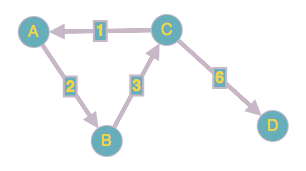

To calculate the PageRank score on a weighted graph, the only modification is we distribute the node score according to the outgoing edge weights instead of evenly distribute. In the matrix solution, we do not need to change anything since the weight information is already encoded in the adjancy matrix. Here are the three implementations of PageRank score on this weighted graph:

In [88]:
#Method 1: Multiplying the matrix iteratively

#this is the new adjancy matrix of our weighted investment graph
A = np.array([[0,0,1,0], [2,0,0,0], [0,3,0,0], [0,0,6,0]])
T = 1000
d = 0.1

#construct the matrix Phat as before
P = A.copy()
P[:, P.sum(0) == 0] = 1
P = P / (P.sum(0)+1e-10)
Phat = (1-d)*P + d/A.shape[0]*np.ones(A.shape)

x = np.ones(A.shape[0])/A.shape[0]
for _ in range(T):
    x = Phat @ x
    x = x/x.sum()
print(x)

[ 0.13892655  0.22505782  0.30257596  0.33343967]


In [89]:
#Method 2: Directly solve the eigen vector

#solve the eigen vector directly
eigenvalues, eigenvectors = np.linalg.eig(Phat)
i = np.argmax(eigenvalues)
v = eigenvectors[:,i]
v = v / v.sum()
print(v)

[ 0.13892655+0.j  0.22505782+0.j  0.30257596+0.j  0.33343967+0.j]


In [95]:
#Method 3: Distribute the node score according to edge weight

A = {'A':{'B':2}, 'B':{'C':3}, 'C':{'A':1,'D':6}, 'D':{}}#this is the new adjancy list of our investment graph

#lookup table for node name and index
node_reverse = {'A': 0, 'B': 1, 'C': 2, 'D': 3}

d = 0.1
T = 1000
n = len(A)
x = np.ones(n)/n

#iterate for T times
for _ in range(T):
    #we are updating the values into a new array since we need to use the original value during calculation
    xnew = np.zeros(n)
    
    for node in A:
        index = node_reverse[node]
        value = x[index] #the previous score
        value = value * (1-d)
        l = len(A[node]) #number of outgoing edges
        
        if l == 0:
            #this node has no outgoing edges, add 
            xnew += np.ones(n) * value / n
        else:
            #distribute the value to each node it points to according to edge weight
            for out_node in A[node]:
                index_out = node_reverse[out_node]
                xnew[index_out] += A[node][out_node] * value / sum(A[node].values())
    xnew += np.ones(n) * d / n #add random jump term
    x = xnew / xnew.sum() #regularize and update in one time

print(x)        

[ 0.13892655  0.22505782  0.30257596  0.33343967]


Notice that in this new weighted graph, node $D$ becomes the most important node instead of node $C$ because of one heavy edge.

## 5. Use NetworkX to solve PageRank

Although PageRank algorithm seems to be only lines of code, in reality, the graphs tend to be very large (think of the size of the Internet!) and you need highly effecient implimentation. NetworkX is a good library when you are dealing with graphs, and it surely has some good PageRank solvers.

There are three functions to solve PageRank score of a graph in NetworkX, they give similar result on most of the cases, but there are still some minor differences in the implementation:
1. networkx.pagerank(): this is a pure-Python implementation of the iterative matrix multipling method. It allows you to use maximal iteration or error tolerance to control the accuracy.
2. networkx.pagerank_scipy(): this function is mostly the same as above, except for it uses scipy sparce matrix representation during calculation.
3. networkx.pagerank_numpy(): this function calles numpy.linalg.eig() to solve the eigen vector directly. There is no accuracy control in this function because it gives the exact solution.

Now we use these three functions to solve our investment problem again:

In [63]:
#create the graph
G = nx.DiGraph()
G.add_edges_from([("A","B"), ("B","C"), ("C","A"), ("C","D")])

#pure python method, here alpha = 1-d
pr1 = nx.pagerank(G, alpha = 0.9, max_iter = 1000)
print("Pure python solution:")
print(pr1)

#scipy matrix method
pr2 = nx.pagerank_scipy(G, alpha = 0.9, max_iter = 1000)
print("Scipy solution:")
print(pr2)

#numpy exact method, this function does not accept max_iter parameter
pr3 = nx.pagerank_numpy(G, alpha = 0.9)
print("Exact solution:")
print(pr3)

Pure python solution:
{'A': 0.2126075277037968, 'B': 0.2641838185655828, 'C': 0.31060112602682377, 'D': 0.2126075277037968}
Scipy solution:
{'A': 0.21260752770379676, 'B': 0.2641838185655828, 'C': 0.31060112602682377, 'D': 0.21260752770379676}
Exact solution:
{'A': 0.21260744985673377, 'B': 0.26418338108882516, 'C': 0.31060171919770757, 'D': 0.21260744985673347}


We can also calculate the weighted PageRank score use NetworkX as below:

In [86]:
G = nx.DiGraph()
G.add_edges_from([("A","B"), ("B","C"), ("C","A"), ("C","D")])
G['A']['B']['w'] = 2
G['B']['C']['w'] = 3
G['C']['A']['w'] = 1
G['C']['D']['w'] = 6
pr1 = nx.pagerank(G, alpha = 0.9, max_iter = 1000, weight='w')
pr2 = nx.pagerank_scipy(G, alpha = 0.9, max_iter = 1000, weight='w')
pr3 = nx.pagerank_numpy(G, alpha = 0.9, weight='w')
print(pr1)
print(pr2)
print(pr3)

{'A': 0.13892639101377735, 'B': 0.2250582106451891, 'C': 0.3025765379147327, 'D': 0.3334388604263008}
{'A': 0.13892639101377735, 'B': 0.22505821064518905, 'C': 0.3025765379147327, 'D': 0.3334388604263008}
{'A': 0.13892654916660027, 'B': 0.22505781960283908, 'C': 0.3025759629954542, 'D': 0.33343966823510646}
